# Simplest test (to debug remapping)

In [27]:
import sys
sys.path.append('..')
%matplotlib inline
%load_ext autoreload
%autoreload 2
import os
import logging
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt

from ase import Atoms
from ase.io import read
from asap3 import FullNeighborList

from m_ff.configurations import carve_confs

from m_ff.kernels import TwoBodySingleSpeciesKernel, ThreeBodySingleSpeciesKernel
from m_ff.gp import GaussianProcess, ThreeBodySingleSpeciesGP, TwoBodySingleSpeciesGP
from m_ff.grid import SingleSpeciesGrid

from m_ff.interpolation import Spline3D, Spline1D
from m_ff.calculators import TwoBodySingleSpecies, ThreeBodySingleSpecies, CombinedSingleSpecies

logging.basicConfig(level=logging.INFO)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Create very simple fake database

In [2]:
# two atoms at 0,1 and at 1, 0

conf0 = np.array([[2., 0., 0.], [0., 2., 0.]])

N = 2
s_n = 0.01
confs = np.hstack((np.tile(conf0, (N, 1)) + np.random.normal(0, s_n, ((N*2, 3))), np.ones(((N*2, 2)))))
confs = np.reshape(confs, (N, 2, 5))

In [3]:
#confs

In [4]:
def force(conf):
    
    r1, r2 = conf[0, 0:3], conf[1, 0:3]
    r3 = r2 - r1
    d1, d2, d3 = np.linalg.norm(r1), np.linalg.norm(r2), np.linalg.norm(r3)
    e = np.exp(-(d1-1.) - (d2-1.) - (d3-1.))
    f = e * (- r1/d1 - r2/d2)
    return f

    

In [5]:
forces = np.zeros((N, 3))

for i in np.arange(N):
    forces[i] =  force(confs[i])


### Train a 3-body GP

In [6]:
theta_3b = [1., 1., 100.]
gp_3 = ThreeBodySingleSpeciesGP(theta=theta_3b, noise=0.001, optimizer=None)

INFO:m_ff.kernels.threebodykernel:Started compilation of theano three body kernels
INFO:m_ff.kernels.threebodykernel:Ended compilation of theano three body kernels


In [7]:
confs.shape

(2, 2, 5)

In [8]:
forces.shape

(2, 3)

In [9]:
gp_3.fit(confs, forces)

preds = gp_3.predict(confs)
print('error is ', np.mean(abs(preds - forces))/np.mean(abs(forces)))

error is  0.00615073718489035


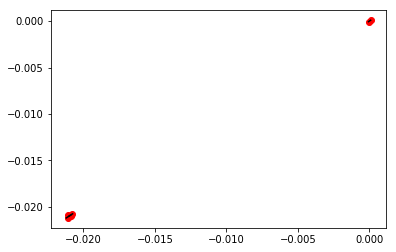

In [10]:
plt.plot(preds, forces, 'ro')
plt.plot(forces, forces, 'k-')
plt.show()

### Map the learned function

In [11]:
grid_start, r_cut, num_3b  = 0.9, 3.5, 20

mapping_dists_3b = np.linspace(grid_start, r_cut, num_3b)

grid_3b = gp_3.build_grid(mapping_dists_3b, 1)


In [12]:
calc = ThreeBodySingleSpecies(r_cut+20, grid_3b)

### Test mapping direcly

In [13]:
gp_forces = np.zeros((N, 3))
gp_energies = np.zeros((N, 3))

m_forces = np.zeros((N, 3))
m_energies = np.zeros((N, 3))

for i in np.arange(N):
    gp_forces[i] =  gp_3.predict(np.array([confs[i]]))
    gp_energies[i] = gp_3.predict_energy(np.array([confs[i]]))

    r1, r2 = confs[i, 0, 0:3], confs[i, 1, 0:3]
    r3 = r2-r1
    d1, d2, d3 = np.linalg.norm(r1) , np.linalg.norm(r2) , np.linalg.norm(r3)          
    n1, n2, n3 = r1/d1, r2/d2, r3/d3
    e, de1, de2, de3 = calc.grid_3b.ev_all(d1, d2, d3)
    
    m_energies[i] = e
    m_forces[i] = (- de1 * n1 - de2 * n2)

energy error is  0.0002849720758728293


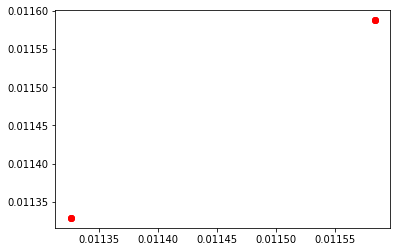

In [14]:
print('energy error is ', np.mean(abs(gp_energies-m_energies)/np.mean(abs(gp_energies))))
plt.plot(m_energies, gp_energies, 'ro')
plt.show()

force error is  0.0046397255531399175


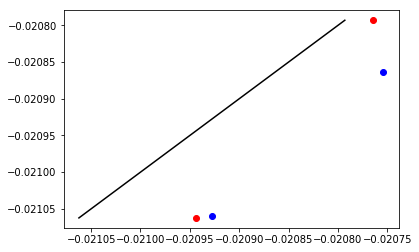

In [15]:
print('force error is ', np.mean(abs(gp_forces-m_forces)/np.mean(abs(gp_forces))))
grid = np.linspace(np.min(gp_forces[:, 0]), np.max(gp_forces[:, 0]), 100)
plt.plot(grid, grid, 'k-')
plt.plot(m_forces[:, 0], gp_forces[:, 0], 'ro')
plt.plot(m_forces[:, 1], gp_forces[:, 1], 'bo')
#plt.plot(m_forces[:, 2], gp_forces[:, 2], 'go')
plt.show()

### Test mapping via the calculator object

In [16]:
gp_forces = np.zeros((N, 3))
gp_energies = np.zeros((N, 3))

m_forces_ = np.zeros((N, 3))
m_energies_ = np.zeros((N, 3))

for i in np.arange(N):
    gp_forces[i] =  gp_3.predict(np.array([confs[i]]))
    gp_energies[i] = gp_3.predict_energy(np.array([confs[i]]))
    
    coords = np.vstack(([0, 0, 0], confs[i, 0:3, 0:3]))
    atoms = Atoms('H3', positions = coords )
    atoms.set_cell([100, 100, 100])
    atoms.set_calculator(calc)
    f = atoms.get_forces()[0, :]
    #f = atoms.get_energy()
    #m_energies[i] = e
    m_forces_[i] = f




INFO:m_ff.calculators:numbers is in system_changes
INFO:m_ff.calculators:initialize


force error is  0.0002849720758728293


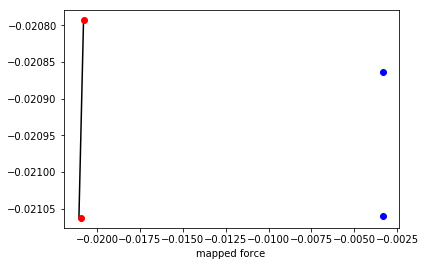

In [17]:
print('force error is ', np.mean(abs(gp_energies-m_energies)/np.mean(abs(gp_energies))))

plt.plot(grid, grid, 'k-')
plt.plot(m_forces[:, 0], gp_forces[:, 0], 'ro')
plt.plot(m_forces_[:, 1], gp_forces[:, 1], 'bo')
#plt.plot(m_forces[:, 2], gp_forces[:, 2], 'go')
plt.xlabel('mapped force')
plt.show()

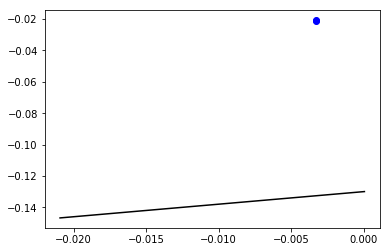

In [18]:
diffgrid = np.linspace(np.min(m_forces_), np.max(m_forces_), 10)

plt.plot(m_forces_[:, 1], m_forces[:, 1], 'bo')
plt.plot(diffgrid, 0.8*diffgrid-0.13, 'k-')

In [28]:
from itertools import combinations, islice


In [31]:
def find_triplets(atoms, nl):
    # atomic_numbers = self.atoms.get_array('numbers', copy=False)

    indices, distances, positions = [], [], dict()

    for i in range(len(atoms)):

        inds, pos, dists2 = nl.get_neighbors(i)

        # Limitation
        assert len(inds) is len(np.unique(inds)), "There are repetitive indices!\n{}".format(inds)

        # ignoring already visited atoms
        inds, pos, dists2 = inds[inds > i], pos[inds > i, :], dists2[inds > i]
        dists = np.sqrt(dists2)

        for local_ind, (j, pos_ij, dist_ij) in enumerate(zip(inds, pos, dists)):

            # Caching local displacement vectors
            positions[(i, j)], positions[(j, i)] = pos_ij / dist_ij, -pos_ij / dist_ij

            for k, dist_ik in islice(zip(inds, dists), local_ind + 1, None):

                try:
                    jk_ind = list(nl[j]).index(k)
                except ValueError:
                    continue  # no valid triplet

                _, _, dists_j = nl.get_neighbors(j)

                indices.append([i, j, k])
                distances.append([dist_ij, np.sqrt(dists_j[jk_ind]), dist_ik])

    return np.array(indices), np.array(distances), positions


In [32]:
m_forces_ = np.zeros((N, 3))

for c in np.arange(N):
    gp_forces[c] =  gp_3.predict(np.array([confs[c]]))
    gp_energies[c] = gp_3.predict_energy(np.array([confs[c]]))
    
    coords = np.vstack(([0, 0, 0], confs[c, 0:3, 0:3]))
    atoms = Atoms('H3', positions = coords )
    atoms.set_cell([100, 100, 100])
    calc = ThreeBodySingleSpecies(r_cut+20, grid_3b)
    calc.initialize(atoms)
    atoms.set_calculator(calc)
    calc.atoms = atoms
    
    
    indices, distances, positions = find_triplets(atoms, calc.nl)
    print(coords)
    print(indices)
    print(distances)
    d_ij, d_jk, d_ki = np.hsplit(distances, 3)
    mapped = calc.grid_3b.ev_all(d_ij, d_jk, d_ki)

    forces = np.zeros((len(atoms), 3))
    
    for (i, j, k), energy, dE_ij, dE_jk, dE_ki in zip(indices, mapped[0], mapped[1], mapped[2], mapped[3]):
        
        forces[i] += - positions[(i, j)] * dE_ij - positions[(i, k)] * dE_ki
        forces[j] += - positions[(j, k)] * dE_jk - positions[(j, i)] * dE_ij
        forces[k] += - positions[(k, i)] * dE_ki - positions[(k, j)] * dE_jk
        
    m_forces_[c] = forces[0]

INFO:m_ff.calculators:initialize
INFO:m_ff.calculators:initialize


[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 2.00397795e+00 -1.64881005e-02 -1.84562147e-03]
 [ 1.41142741e-03  2.00521100e+00  7.79136456e-03]]
[[0 1 2]]
[[2.00404663 2.845634   2.00522664]]
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 2.01877780e+00  6.56611521e-04 -4.85291932e-03]
 [-9.47582128e-03  2.00218202e+00 -3.60113125e-03]]
[[0 1 2]]
[[2.01878374 2.84954703 2.00220768]]


force error is  0.0046397255531399175


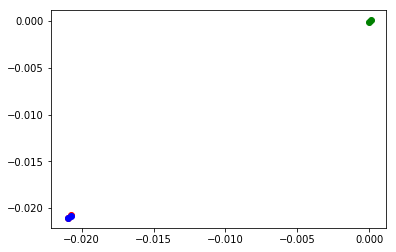

In [33]:
print('force error is ', np.mean(abs(gp_forces-m_forces)/np.mean(abs(gp_forces))))
grid = np.linspace(np.min(gp_forces[:, 0]), np.max(gp_forces[:, 0]), 100)
plt.plot(grid, grid, 'k-')
plt.plot(m_forces[:, 0], gp_forces[:, 0], 'ro')
plt.plot(m_forces_[:, 1], gp_forces[:, 1], 'bo')
plt.plot(m_forces[:, 2], gp_forces[:, 2], 'go')
plt.show()

In [21]:
#dir(calc)


In [22]:
calc.atoms

Atoms(symbols='H3', pbc=False, cell=[100.0, 100.0, 100.0], calculator=ThreeBodySingleSpecies(...))